# Data detail
This notebook consist the states of devices tracked using Home Assistant and it relations.

## Data source
Home assistant sqlite database. Database located in `/config/home-assistant_v2.db`

The database is converted to `csv` format prior to importing to Jupyter notebook.

From the database, only `states` table is provided in this notebook.

Furthermore, the `csv` provided is the stripped version after removing private information and unnecessary data.

## Data provider
### Hardware
1. Server: Raspberry Pi 4 running [HomeAssistant OS](https://www.home-assistant.io/)
2. Zigbee coordinator: [Sonoff ZbBridge](https://zigbee.blakadder.com/Sonoff_ZBBridge.html) flashed with custom [Tasmota firmware](https://tasmota.github.io/docs/)
3. Zigbee devices:
  - Xiaomi humidity & temperature sensor [MCCGQ01LM](https://zigbee.blakadder.com/Xiaomi_MCCGQ01LM.html)
  - Sonoff humidity & temperature sensor [SNZB-02](https://zigbee.blakadder.com/Sonoff_SNZB-02.html)
  - Xiaomi contact sensor [MCCGQ01LM](https://zigbee.blakadder.com/Xiaomi_MCCGQ01LM.html)
  - Xiaomi 2 gang wall switch [QBKG03LM](https://zigbee.blakadder.com/Xiaomi_QBKG03LM.html)
4. Wifi device: Smart socket [Anoopsyche SP15 Plug](https://templates.blakadder.com/anoopsyche_SP15.html) running custom [Tasmota firmware](https://tasmota.github.io/docs/)
### Software
1. [HomeAssistant OS](https://www.home-assistant.io/)
2. MQTT broker: [mosquitto](https://mosquitto.org/)
3. Home assistant integration:
    - [Tasmota](https://www.home-assistant.io/integrations/tasmota)
    - [MQTT](https://www.home-assistant.io/integrations/mqtt)

# Preparation
## Importing raw `csv` file for cleaning

In [1]:
# import neccesary package/modules
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
# import csv data
# 'has' is used as a short form for home-assistant
has_raw = pd.read_csv("../data/states.csv")
has_raw.shape

(36825, 10)

## Removing private infomation and unnecessary data points.
Example of data removed:
- Private infomation:
    - Precise GPS location
    - Public IP addresses
    - Device MAC addresses
    - Person name
- Unnecessary
    - Automation details
    - Logs & notification
    - Helper for automation internal use

In [3]:
# list of data to be removed, and creating new dataframe
to_drop = [
    "device_tracker", 
    "automation", 
    "sun", 
    "person", 
    "script",
    "zone",
    "timer",
    "persistent_notification",
    "input_number",
    "vacuum",
    "media_player",
    "climate",
    "light",
    "counter"
    ]

has_cleaned = has_raw[~has_raw["domain"].isin(to_drop)]
has_cleaned.shape

(2867, 10)

## Creating new csv file
Only this file will be uploaded to GitHub.

All analysis will be based on this file only, not on the raw `csv` file

In [4]:
# export to new csv file
has_cleaned.to_csv("../data/states_cleaned.csv", index=False) # don't forget to remove index column

## Importing stripped data for analysis

In [5]:
has_data = pd.read_csv("../data/states_cleaned.csv")
has_data.head()

,state_id,domain,entity_id,state,attributes,event_id,last_changed,last_updated,created,old_state_id
0,239622,sensor,sensor.xiaomiht_temp,29.84,"{""unit_of_measurement"": ""C"", ""friendly_name"": ...",250334,2021-07-07 20:16:25.507284,2021-07-07 20:16:25.507284,2021-07-07 20:16:25.507284,NaN
1,239623,sensor,sensor.xiaomiht_humi,83.5,"{""unit_of_measurement"": ""%"", ""friendly_name"": ...",250335,2021-07-07 20:16:25.508019,2021-07-07 20:16:25.508019,2021-07-07 20:16:25.508019,NaN
2,239860,sensor,sensor.sonoffht_humi,86.36,"{""unit_of_measurement"": ""%"", ""friendly_name"": ...",250588,2021-07-07 20:39:26.752361,2021-07-07 20:39:26.752361,2021-07-07 20:39:26.752361,NaN
3,239867,sensor,sensor.sonoffht_temp,29.97,"{""unit_of_measurement"": ""C"", ""friendly_name"": ...",250597,2021-07-07 20:39:43.475842,2021-07-07 20:39:43.475842,2021-07-07 20:39:43.475842,NaN
4,239876,sensor,sensor.sonoffht_humi,84.99,"{""unit_of_measurement"": ""%"", ""friendly_name"": ...",250606,2021-07-07 20:39:56.796520,2021-07-07 20:39:56.796520,2021-07-07 20:39:56.796520,239860.0


In [6]:
has_data.shape

(2867, 10)

Note(s): This data file only consist of 2867 rows of data, compared to 36825 rows in raw `csv` file.

In [7]:
# Converting date from object type to datetime type
has_data.iloc[:, 6:9] = has_data.iloc[:, 6:9].apply(pd.to_datetime)
has_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2867 entries, 0 to 2866
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   state_id      2867 non-null   int64         
 1   domain        2867 non-null   object        
 2   entity_id     2867 non-null   object        
 3   state         2866 non-null   object        
 4   attributes    2867 non-null   object        
 5   event_id      2867 non-null   int64         
 6   last_changed  2867 non-null   datetime64[ns]
 7   last_updated  2867 non-null   datetime64[ns]
 8   created       2867 non-null   datetime64[ns]
 9   old_state_id  2811 non-null   float64       
dtypes: datetime64[ns](3), float64(1), int64(2), object(4)
memory usage: 224.1+ KB


In [8]:
# replacing str object in "attributes" column to json
# important, so it can be flatten using pandas function
has_data["attributes"] = has_data["attributes"].apply(json.loads)

In [9]:
has_data["entity_id"].unique()

array(['sensor.xiaomiht_temp', 'sensor.xiaomiht_humi',
       'sensor.sonoffht_humi', 'sensor.sonoffht_temp',
       'switch.airpurifier', 'switch.br3walllight', 'switch.br3wallfan',
       'binary_sensor.xiaomiac'], dtype=object)

### Extracting json data for `attributes` column
`pd.json_normalize` fucntion will be used to extract this data to an individual columns

In [10]:
# Creating new dataframe consist of flatten json data
has_json = pd.json_normalize(has_data.attributes[:])
has_json


,unit_of_measurement,friendly_name,device_class,icon,restored,supported_features
0,C,Temperature,temperature,NaN,NaN,NaN
1,%,Humidity,humidity,NaN,NaN,NaN
2,%,Humidity,humidity,NaN,NaN,NaN
3,C,Temperature,temperature,NaN,NaN,NaN
4,%,Humidity,humidity,NaN,NaN,NaN
...,...,...,...,...,...,...
2862,NaN,Light,NaN,mdi:ceiling-light,NaN,NaN
2863,NaN,Light,NaN,mdi:ceiling-light,NaN,NaN
2864,C,Temperature,temperature,NaN,NaN,NaN
2865,%,Humidity,humidity,NaN,NaN,NaN


In [11]:
has_json["device_class"].unique()

array(['temperature', 'humidity', nan, 'power'], dtype=object)

### Adding json dataframe to existing dataframe
By using `pd.concat` function

These dataframe should be added to a new column, not a new row.

In [12]:
has_data = pd.concat([has_data, has_json], axis=1) # without axis=1, has_json will be added at the bottom row
has_data

,state_id,domain,entity_id,state,attributes,event_id,last_changed,last_updated,created,old_state_id,unit_of_measurement,friendly_name,device_class,icon,restored,supported_features
0,239622,sensor,sensor.xiaomiht_temp,29.84,"{'unit_of_measurement': 'C', 'friendly_name': ...",250334,2021-07-07 20:16:25.507284,2021-07-07 20:16:25.507284,2021-07-07 20:16:25.507284,NaN,C,Temperature,temperature,NaN,NaN,NaN
1,239623,sensor,sensor.xiaomiht_humi,83.5,"{'unit_of_measurement': '%', 'friendly_name': ...",250335,2021-07-07 20:16:25.508019,2021-07-07 20:16:25.508019,2021-07-07 20:16:25.508019,NaN,%,Humidity,humidity,NaN,NaN,NaN
2,239860,sensor,sensor.sonoffht_humi,86.36,"{'unit_of_measurement': '%', 'friendly_name': ...",250588,2021-07-07 20:39:26.752361,2021-07-07 20:39:26.752361,2021-07-07 20:39:26.752361,NaN,%,Humidity,humidity,NaN,NaN,NaN
3,239867,sensor,sensor.sonoffht_temp,29.97,"{'unit_of_measurement': 'C', 'friendly_name': ...",250597,2021-07-07 20:39:43.475842,2021-07-07 20:39:43.475842,2021-07-07 20:39:43.475842,NaN,C,Temperature,temperature,NaN,NaN,NaN
4,239876,sensor,sensor.sonoffht_humi,84.99,"{'unit_of_measurement': '%', 'friendly_name': ...",250606,2021-07-07 20:39:56.796520,2021-07-07 20:39:56.796520,2021-07-07 20:39:56.796520,239860.0,%,Humidity,humidity,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2862,441354,switch,switch.br3walllight,on,"{'friendly_name': 'Light', 'icon': 'mdi:ceilin...",467370,2021-07-18 04:03:38.460080,2021-07-18 04:03:38.460080,2021-07-18 04:03:38.460080,441326.0,NaN,Light,NaN,mdi:ceiling-light,NaN,NaN
2863,441396,switch,switch.br3walllight,off,"{'friendly_name': 'Light', 'icon': 'mdi:ceilin...",467415,2021-07-18 04:04:58.468532,2021-07-18 04:04:58.468532,2021-07-18 04:04:58.468532,441354.0,NaN,Light,NaN,mdi:ceiling-light,NaN,NaN
2864,441514,sensor,sensor.xiaomiht_temp,30.75,"{'unit_of_measurement': 'C', 'friendly_name': ...",467540,2021-07-18 04:11:10.427881,2021-07-18 04:11:10.427881,2021-07-18 04:11:10.427881,440818.0,C,Temperature,temperature,NaN,NaN,NaN
2865,441515,sensor,sensor.xiaomiht_humi,84.65,"{'unit_of_measurement': '%', 'friendly_name': ...",467541,2021-07-18 04:11:10.428663,2021-07-18 04:11:10.428663,2021-07-18 04:11:10.428663,440819.0,%,Humidity,humidity,NaN,NaN,NaN


### Fill up missing `device_class`
Based on how my home assistant is set up, all the manually added device is missing the optional parameter

Line below will fill up the NaN values with `power` class

In [13]:
# has_data["unit_of_measurement"] = has_data["unit_of_measurement"].fillna("power")
has_data["device_class"] = has_data["device_class"].fillna("power")
has_data

,state_id,domain,entity_id,state,attributes,event_id,last_changed,last_updated,created,old_state_id,unit_of_measurement,friendly_name,device_class,icon,restored,supported_features
0,239622,sensor,sensor.xiaomiht_temp,29.84,"{'unit_of_measurement': 'C', 'friendly_name': ...",250334,2021-07-07 20:16:25.507284,2021-07-07 20:16:25.507284,2021-07-07 20:16:25.507284,NaN,C,Temperature,temperature,NaN,NaN,NaN
1,239623,sensor,sensor.xiaomiht_humi,83.5,"{'unit_of_measurement': '%', 'friendly_name': ...",250335,2021-07-07 20:16:25.508019,2021-07-07 20:16:25.508019,2021-07-07 20:16:25.508019,NaN,%,Humidity,humidity,NaN,NaN,NaN
2,239860,sensor,sensor.sonoffht_humi,86.36,"{'unit_of_measurement': '%', 'friendly_name': ...",250588,2021-07-07 20:39:26.752361,2021-07-07 20:39:26.752361,2021-07-07 20:39:26.752361,NaN,%,Humidity,humidity,NaN,NaN,NaN
3,239867,sensor,sensor.sonoffht_temp,29.97,"{'unit_of_measurement': 'C', 'friendly_name': ...",250597,2021-07-07 20:39:43.475842,2021-07-07 20:39:43.475842,2021-07-07 20:39:43.475842,NaN,C,Temperature,temperature,NaN,NaN,NaN
4,239876,sensor,sensor.sonoffht_humi,84.99,"{'unit_of_measurement': '%', 'friendly_name': ...",250606,2021-07-07 20:39:56.796520,2021-07-07 20:39:56.796520,2021-07-07 20:39:56.796520,239860.0,%,Humidity,humidity,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2862,441354,switch,switch.br3walllight,on,"{'friendly_name': 'Light', 'icon': 'mdi:ceilin...",467370,2021-07-18 04:03:38.460080,2021-07-18 04:03:38.460080,2021-07-18 04:03:38.460080,441326.0,NaN,Light,power,mdi:ceiling-light,NaN,NaN
2863,441396,switch,switch.br3walllight,off,"{'friendly_name': 'Light', 'icon': 'mdi:ceilin...",467415,2021-07-18 04:04:58.468532,2021-07-18 04:04:58.468532,2021-07-18 04:04:58.468532,441354.0,NaN,Light,power,mdi:ceiling-light,NaN,NaN
2864,441514,sensor,sensor.xiaomiht_temp,30.75,"{'unit_of_measurement': 'C', 'friendly_name': ...",467540,2021-07-18 04:11:10.427881,2021-07-18 04:11:10.427881,2021-07-18 04:11:10.427881,440818.0,C,Temperature,temperature,NaN,NaN,NaN
2865,441515,sensor,sensor.xiaomiht_humi,84.65,"{'unit_of_measurement': '%', 'friendly_name': ...",467541,2021-07-18 04:11:10.428663,2021-07-18 04:11:10.428663,2021-07-18 04:11:10.428663,440819.0,%,Humidity,humidity,NaN,NaN,NaN


### Creating additional columns for extra details
Add 5 more columns, fill with respective data:
- temperature
- humidity
- power
- date
- time

In [14]:
# Creating new columns with default value
has_data["temperature_in_C"], has_data["humidity_in_%"], has_data["power"] = np.NaN, np.NaN, "on"
# Filling columns with repective values
has_data.loc[(has_data.device_class == "temperature"), "temperature_in_C"] = has_data["state"]
has_data.loc[(has_data.device_class == "humidity"), "humidity_in_%"] = has_data["state"]

has_data.loc[(has_data.device_class == "power"), "power"] = has_data["state"]

# Filling NaN with previous/next value
has_data["temperature_in_C"] = has_data["temperature_in_C"].fillna(method='ffill',) # method='ffill': fill with previous value
has_data["humidity_in_%"] = has_data["humidity_in_%"].fillna(method='bfill',) # method='bfill': fill with next value

# Removing temperature & humidity for !sensor
has_data.loc[(has_data.domain != "sensor"), "temperature_in_C"] = np.NaN
has_data.loc[(has_data.domain != "sensor"), "humidity_in_%"] = np.NaN


# Renaming column
has_data.rename(columns={"last_updated":"date"}, inplace=True)

has_data

,state_id,domain,entity_id,state,attributes,event_id,last_changed,date,created,old_state_id,unit_of_measurement,friendly_name,device_class,icon,restored,supported_features,temperature_in_C,humidity_in_%,power
0,239622,sensor,sensor.xiaomiht_temp,29.84,"{'unit_of_measurement': 'C', 'friendly_name': ...",250334,2021-07-07 20:16:25.507284,2021-07-07 20:16:25.507284,2021-07-07 20:16:25.507284,NaN,C,Temperature,temperature,NaN,NaN,NaN,29.84,83.5,on
1,239623,sensor,sensor.xiaomiht_humi,83.5,"{'unit_of_measurement': '%', 'friendly_name': ...",250335,2021-07-07 20:16:25.508019,2021-07-07 20:16:25.508019,2021-07-07 20:16:25.508019,NaN,%,Humidity,humidity,NaN,NaN,NaN,29.84,83.5,on
2,239860,sensor,sensor.sonoffht_humi,86.36,"{'unit_of_measurement': '%', 'friendly_name': ...",250588,2021-07-07 20:39:26.752361,2021-07-07 20:39:26.752361,2021-07-07 20:39:26.752361,NaN,%,Humidity,humidity,NaN,NaN,NaN,29.84,86.36,on
3,239867,sensor,sensor.sonoffht_temp,29.97,"{'unit_of_measurement': 'C', 'friendly_name': ...",250597,2021-07-07 20:39:43.475842,2021-07-07 20:39:43.475842,2021-07-07 20:39:43.475842,NaN,C,Temperature,temperature,NaN,NaN,NaN,29.97,84.99,on
4,239876,sensor,sensor.sonoffht_humi,84.99,"{'unit_of_measurement': '%', 'friendly_name': ...",250606,2021-07-07 20:39:56.796520,2021-07-07 20:39:56.796520,2021-07-07 20:39:56.796520,239860.0,%,Humidity,humidity,NaN,NaN,NaN,29.97,84.99,on
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2862,441354,switch,switch.br3walllight,on,"{'friendly_name': 'Light', 'icon': 'mdi:ceilin...",467370,2021-07-18 04:03:38.460080,2021-07-18 04:03:38.460080,2021-07-18 04:03:38.460080,441326.0,NaN,Light,power,mdi:ceiling-light,NaN,NaN,NaN,NaN,on
2863,441396,switch,switch.br3walllight,off,"{'friendly_name': 'Light', 'icon': 'mdi:ceilin...",467415,2021-07-18 04:04:58.468532,2021-07-18 04:04:58.468532,2021-07-18 04:04:58.468532,441354.0,NaN,Light,power,mdi:ceiling-light,NaN,NaN,NaN,NaN,off
2864,441514,sensor,sensor.xiaomiht_temp,30.75,"{'unit_of_measurement': 'C', 'friendly_name': ...",467540,2021-07-18 04:11:10.427881,2021-07-18 04:11:10.427881,2021-07-18 04:11:10.427881,440818.0,C,Temperature,temperature,NaN,NaN,NaN,30.75,84.65,on
2865,441515,sensor,sensor.xiaomiht_humi,84.65,"{'unit_of_measurement': '%', 'friendly_name': ...",467541,2021-07-18 04:11:10.428663,2021-07-18 04:11:10.428663,2021-07-18 04:11:10.428663,440819.0,%,Humidity,humidity,NaN,NaN,NaN,30.75,84.65,on


### Converting data to correct data type
Eventhough some of the data is display as int/float, those imported data may not be in correct type, some of these are imported as str.

In [15]:
has_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2867 entries, 0 to 2866
Data columns (total 19 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   state_id             2867 non-null   int64         
 1   domain               2867 non-null   object        
 2   entity_id            2867 non-null   object        
 3   state                2866 non-null   object        
 4   attributes           2867 non-null   object        
 5   event_id             2867 non-null   int64         
 6   last_changed         2867 non-null   datetime64[ns]
 7   date                 2867 non-null   datetime64[ns]
 8   created              2867 non-null   datetime64[ns]
 9   old_state_id         2811 non-null   float64       
 10  unit_of_measurement  2088 non-null   object        
 11  friendly_name        2867 non-null   object        
 12  device_class         2867 non-null   object        
 13  icon                 779 non-null

### More cleaning
Dropping unwanted columns

Remove trailing decimal in time

In [16]:
# Droping columns
has_data = has_data.drop([
            "state_id",
            "attributes",
            "event_id",
            "old_state_id",
            "icon",
            "restored",
            "supported_features",
            "created", 
            "last_changed",
            #"last_updated",
            "unit_of_measurement",
            "state"], 
            axis=1)

# Removing trailing decimal in time
#has_data["time"] = has_data["time"].astype(str).apply(lambda x : x[:-7])

# Removing redundant sensor data
has_data.drop(has_data[has_data["entity_id"] == "sensor.xiaomiht_temp"].index, inplace=True)
has_data.drop(has_data[has_data["entity_id"] == "sensor.sonoffht_temp"].index, inplace=True)
has_data.drop(has_data[has_data["entity_id"] == "switch.airpurifier"].index, inplace=True)
has_data.drop(has_data[has_data["entity_id"] == "switch.br3walllight"].index, inplace=True)

# Renaming sensor name
has_data["entity_id"].replace({"sensor.xiaomiht_humi": "sensor.xiaomiht", "sensor.sonoffht_humi": "sensor.sonoffht"}, inplace=True)


has_data

,domain,entity_id,date,friendly_name,device_class,temperature_in_C,humidity_in_%,power
1,sensor,sensor.xiaomiht,2021-07-07 20:16:25.508019,Humidity,humidity,29.84,83.5,on
2,sensor,sensor.sonoffht,2021-07-07 20:39:26.752361,Humidity,humidity,29.84,86.36,on
4,sensor,sensor.sonoffht,2021-07-07 20:39:56.796520,Humidity,humidity,29.97,84.99,on
5,sensor,sensor.sonoffht,2021-07-07 20:40:26.861851,Humidity,humidity,29.97,86.36,on
6,sensor,sensor.sonoffht,2021-07-07 20:40:58.150382,Humidity,humidity,29.97,85.28,on
...,...,...,...,...,...,...,...,...
2855,sensor,sensor.sonoffht,2021-07-18 03:33:27.429700,Humidity,humidity,30.68,87.81,on
2858,switch,switch.br3wallfan,2021-07-18 04:02:27.789987,Fan,power,NaN,NaN,off
2860,switch,switch.br3wallfan,2021-07-18 04:03:38.200405,Fan,power,NaN,NaN,on
2865,sensor,sensor.xiaomiht,2021-07-18 04:11:10.428663,Humidity,humidity,30.75,84.65,on


In [17]:
has_data["power"].unique()

array(['on', 'off'], dtype=object)

### Rearrange columns
Optional step, but it for easier reference during analysis

In [18]:
# Rearrange columns
cols = ["date",'entity_id', "temperature_in_C", "humidity_in_%", "power",'domain', 'friendly_name', 'device_class']

has_data = has_data[cols]

### Final check of DataFrame before analysis
1. Make sure all columns is in correct datatypes:
    - date & time as `datetime`
    - numerical value as `int` or `float`
    - json data is converted from `str` object to `json` object
2. Remove unnecessary data/columns/rows

In [19]:
has_data["temperature_in_C"] = pd.to_numeric(has_data["temperature_in_C"], errors="coerce") # errors="coerce": setting invalid values as NaN
has_data["humidity_in_%"] = pd.to_numeric(has_data["humidity_in_%"], errors="coerce")

has_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1642 entries, 1 to 2866
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   date              1642 non-null   datetime64[ns]
 1   entity_id         1642 non-null   object        
 2   temperature_in_C  1357 non-null   float64       
 3   humidity_in_%     1359 non-null   float64       
 4   power             1642 non-null   object        
 5   domain            1642 non-null   object        
 6   friendly_name     1642 non-null   object        
 7   device_class      1642 non-null   object        
dtypes: datetime64[ns](1), float64(2), object(5)
memory usage: 115.5+ KB


In [20]:
# Checking for NaN values
has_data.isnull().sum()

date                  0
entity_id             0
temperature_in_C    285
humidity_in_%       283
power                 0
domain                0
friendly_name         0
device_class          0
dtype: int64

# Analysis
create function:
- create a graph
- ask for date, time, sensor


In [21]:
has_data.groupby("entity_id").head()

,date,entity_id,temperature_in_C,humidity_in_%,power,domain,friendly_name,device_class
1,2021-07-07 20:16:25.508019,sensor.xiaomiht,29.84,83.50,on,sensor,Humidity,humidity
2,2021-07-07 20:39:26.752361,sensor.sonoffht,29.84,86.36,on,sensor,Humidity,humidity
4,2021-07-07 20:39:56.796520,sensor.sonoffht,29.97,84.99,on,sensor,Humidity,humidity
5,2021-07-07 20:40:26.861851,sensor.sonoffht,29.97,86.36,on,sensor,Humidity,humidity
6,2021-07-07 20:40:58.150382,sensor.sonoffht,29.97,85.28,on,sensor,Humidity,humidity
8,2021-07-07 21:14:54.198185,sensor.xiaomiht,29.87,83.54,on,sensor,Humidity,humidity
10,2021-07-07 21:40:57.799986,sensor.sonoffht,29.85,86.21,on,sensor,Humidity,humidity
12,2021-07-07 22:07:31.494619,sensor.xiaomiht,29.96,83.84,on,sensor,Humidity,humidity
15,2021-07-07 22:59:28.649551,sensor.xiaomiht,29.76,83.94,on,sensor,Humidity,humidity
22,2021-07-07 23:54:06.375989,sensor.xiaomiht,29.89,84.44,on,sensor,Humidity,humidity


## Ploting line graph for continuous data series
### Below shows the fluctuation of temperature throughout the month
Pivot table is used to correctly extract the data needed from the dataframe

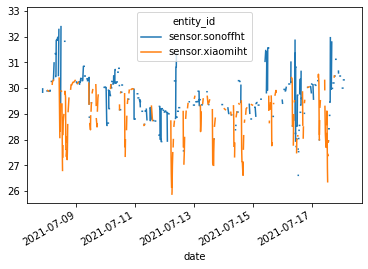

In [22]:
has_data.pivot_table(values="temperature_in_C", index='date', columns="entity_id").plot();

### Graph below shows the fluctuation of humidity throughout the period of observation
Pivot table is used again to produce the line chart below

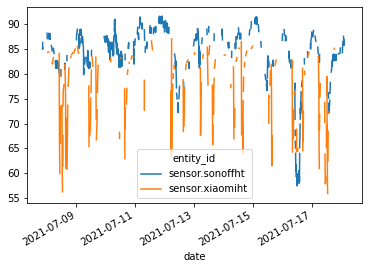

In [23]:
has_data.pivot_table(values="humidity_in_%", index='date', columns="entity_id").plot();

### Scatter plot show the relationship between temperature in C and relative humidity in %
According to [Wikipedia](https://en.wikipedia.org/wiki/Room_temperature), the acceptable temperatures ranges between 25–32 °C with relative humidity of 40% – 60%

High temperature and relative humidity may cause body to overheat due to inability to release body heat.

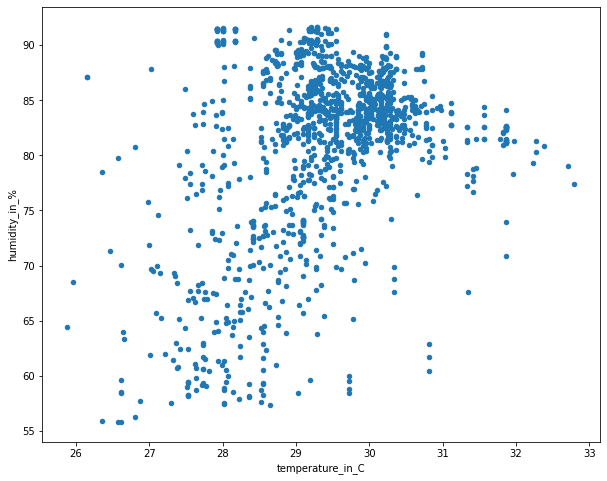

In [24]:
has_data.plot(kind="scatter", x="temperature_in_C", y="humidity_in_%", figsize=(10,8));

In [47]:
class Ask_for_data(object):
    """ Temperature & Humidity History """
    error_count = 0
    def __init__(self):
        print("Hi, you may use this app to get info such as line/scatter plot, temperature & humidity data")
        
    def show_graph(self):
        self.graph_type = input("Please specify graph type (line/scatter): ")
        # Resetting error count to 0
        self.error_count = 0
        # Input validation
        while self.graph_type not in ("line","scatter"):
            self.error_count += 1
            if self.error_count < 4:
                self.graph_type = input("Invalid input. Please try again (line/scatter):")
            else:
                print("Program terminated. Please contact support for help.")
                break
        
        if (self.graph_type == "scatter"):
            print("Graph below shows the relationship between indoor temperature & relative humidity for the observation period.")
            return has_data.plot(kind="scatter", x="temperature_in_C", y="humidity_in_%", figsize=(10,8));
        elif (self.graph_type == "line"):
            self.line_type = input("Please select type (temp/humi): ")
            
            # Input validation
            while self.line_type not in ("temp","humi"):
                self.error_count += 1
                if self.error_count < 4:
                    self.line_type = input("Invalid input. Please try again (temp/humi):")
                else:
                    print("Program terminated. Please contact support for help.")
                    break
                
            if (self.line_type == "temp"):
                print("The graph shows the temperature of the room throughout the observation period.")
                return has_data.pivot_table(values="temperature_in_C", index='date', columns="entity_id").plot();
            elif (self.line_type == "humi"):
                print("The graph shows the relative humidity of the room throughout the observation period.")
                return has_data.pivot_table(values="humidity_in_%", index='date', columns="entity_id").plot();

    
    def query_temp(self, kind=""):
        # Resetting error count to 0
        self.error_count = 0
        # extracting data from the dataframe
        self.temp_min = has_data["temperature_in_C"].min()
        self.temp_max = has_data["temperature_in_C"].max()
        self.temp_mean = has_data["temperature_in_C"].mean()
        
        self.kind = input("Please specify the temperature data that you want (min/max/mean/all):")
        # Checking for valid input
        while self.kind not in ["min","max","mean","all",""]:
            self.error_count += 1
            if self.error_count < 4:
                self.kind = input("Invalid input, please try again. The options are (min/max/mean/all)")
            else:
                print("Program terminated. Please contact support for help.")
                break
        
        if self.kind == "min":
            print(f"The minimum temperature of the month is {self.temp_min}.")
        elif self.kind == "max":
            print(f"The maximum temperature of the month is {self.temp_max}.")
        elif self.kind == "mean":
            print(f"The average temperature of the month is {self.temp_mean:.2f}.")
        elif (self.kind == "all") or (self.kind == ""):
            print(f"The temperature of the month are: Lowest: {self.temp_min}. Highest: {self.temp_max}. Average of {self.temp_mean:.2f}")
    
    def query_humi(self, kind=""):
        # Resetting error count to 0
        self.error_count = 0
        # extracting data from the dataframe
        self.humi_min = has_data["humidity_in_%"].min()
        self.humi_max = has_data["humidity_in_%"].max()
        self.humi_mean = has_data["humidity_in_%"].mean()
        
        self.kind = input("Please specify the relative humidity data that you want (min/max/mean/all):")
        # Checking for valid input
        while self.kind not in ["min","max","mean","all",""]:
            self.error_count += 1
            if self.error_count < 4:
                self.kind = input("Invalid input, please try again. The options are (min/max/mean/all)")
            else:
                print("Program terminated. Please contact support for help.")
                break
        
        if self.kind == "min":
            print(f"The minimum temperature of the month is {self.humi_min}.")
        elif self.kind == "max":
            print(f"The maximum temperature of the month is {self.humi_max}.")
        elif self.kind == "mean":
            print(f"The average temperature of the month is {self.humi_mean:.2f}.")
        elif (self.kind == "all") or (self.kind == ""):
            print(f"The temperature of the month are: Lowest: {self.humi_min}%. Highest: {self.humi_max}%. Average of {self.humi_mean:.2f}%")

In [48]:
ask = Ask_for_data()

Hi, you may use this app to get info such as line/scatter plot, temperature & humidity data


Please specify graph type (line/scatter): fsasd
Invalid input. Please try again (line/scatter):ea
Invalid input. Please try again (line/scatter):line
Please select type (temp/humi): fda
Invalid input. Please try again (temp/humi):temp
The graph shows the temperature of the room throughout the observation period.


<AxesSubplot:xlabel='date'>

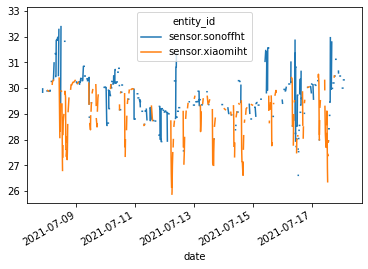

In [49]:
ask.show_graph()

In [50]:
ask.query_temp()

Please specify the temperature data that you want (min/max/mean/all):efas
Invalid input, please try again. The options are (min/max/mean/all)fdas
Invalid input, please try again. The options are (min/max/mean/all)ea
Invalid input, please try again. The options are (min/max/mean/all)min
The minimum temperature of the month is 25.88.


In [51]:
ask.query_humi()

Please specify the relative humidity data that you want (min/max/mean/all):fads
Invalid input, please try again. The options are (min/max/mean/all)eaf
Invalid input, please try again. The options are (min/max/mean/all)fae
Invalid input, please try again. The options are (min/max/mean/all)fdsa
Program terminated. Please contact support for help.
